# Imports

In [ ]:
!nvidia-smi

Sat Dec  3 20:49:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers --quiet
!pip install sentencepiece --quiet

     |████████████████████████████████| 5.8 MB 17.6 MB/s 
     |████████████████████████████████| 182 kB 74.7 MB/s 
     |████████████████████████████████| 7.6 MB 59.8 MB/s 
     |████████████████████████████████| 1.3 MB 35.0 MB/s 


In [ ]:
import os
import sys
import time
import string
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, \
  LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from transformers import BertTokenizer, TFBertModel, AutoModel, AutoTokenizer
from transformers import BertConfig, BertTokenizer, TFBertModel
import transformers

## Global Variables and Google Drive Connect

In [ ]:
TESTING = False # use to truncate training data in order to speed up development

RANDOM_STATE = 42
SEQUENCE_LENGTH = 512
BATCH_SIZE = 1
USER = 'HIDDEN'
RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
PATIENCE = 2
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = 0.1
EPOCHS = 4
# Uncomment these two lines if you want to be able to be able to repeat calculations exactly on the same hardware
# However, the model will run more slowly (approx 1/3 speed)
# tf.keras.utils.set_random_seed(RANDOM_STATE)
# tf.config.experimental.enable_op_determinism()

In [ ]:
# Mount drive where you will do your work.
drive.mount('/content/drive')
root_dir = "NOT SHOW FOR PRIVACY PURPOSES"
project_folder = "NOT SHOW FOR PRIVACY PURPOSES"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # to test if all is working, you can uncomment these two lines below--it should write a file to the shared drive
  # !touch 'new_file_in_working_directory.txt'
  # print('\nYour working directory was changed to ' + root_dir + project_folder + \
  #       "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

os.chdir(root_dir + project_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data and Create Data Sets

In [ ]:
#Pull training data with all columns
X_train = pd.read_csv('data/processed/X_train.csv')
y_train = pd.read_csv('data/processed/y_train.csv')

#pull validation data with all columns 
X_val = pd.read_csv('data/processed/X_val.csv')
y_val = pd.read_csv('data/processed/y_val.csv')

# # #pull test data with all columns
X_test = pd.read_csv('data/processed/X_test.csv')
y_test = pd.read_csv('data/processed/y_test.csv')
test_data = pd.merge(X_test, y_test, on='essay_index', how='outer')

test_data = test_data[['full_text', 'cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
test_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

#drop all non-text columns and concatenate train and val into one dataset
train_data = pd.merge(X_train, y_train, on='essay_index', how='outer')
validation_data = pd.merge(X_val, y_val, on='essay_index', how='outer')

#create train set
train_data = train_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
train_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

#create val set
val_data = validation_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
val_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

print("train data size is: {}".format(train_data.shape))
print("test size is: {}".format(val_data.shape))

train data size is: (2347, 7)
test size is: (782, 7)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
if TESTING:
    train_size = 250
    val_size = 3

    print("=========================================\nIN TESTING MODE\n=========================================")

    else:
        train_size = 2347
        val_size = 782

train_data = train_data[:train_size]
val_data = val_data[:val_size]

print("input_data size is: {}".format(train_data.shape))
print("validation data size is: {}".format(val_data.shape))
print("Test data size is: {}".format(test_data.shape))

input_data size is: (2347, 7)
validation data size is: (782, 7)
Test data size is: (782, 7)


## Tokenize Data

In [ ]:
bert_model = transformers.TFAutoModel.from_pretrained('bert-base-cased') 
bert_tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-cased') 

deberta_model = AutoModel.from_pretrained("microsoft/deberta-v3-base")
deberta_tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

auto_tune = tf.data.experimental.AUTOTUNE

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def bert_encode(texts, tokenizer, attn_mask):
    """
    Encodes the given texts using the provided tokenizer and returns the input
    IDs and attention mask.

    Args:
    - texts (list of str): A list of strings representing the texts to be
    encoded.
    - tokenizer (TensorFlow tokenizer): An instance of a tokenizer to be used
    for tokenization.
    - attn_mask (array): A boolean indicating whether to include the attention
    mask in the output.

    Returns:
    - input_ids: A NumPy array of shape (n_texts, max_sequence_length)
    representing the input IDs of the encoded texts.
    - attention_mask: A NumPy array of shape (n_texts, max_sequence_length)
    representing the attention mask of the encoded texts, if attn_mask=True.
    """ 
    input_ids = []
    attention_mask = []
    
    for text in texts.tolist():
        token = tokenizer(text, 
                          add_special_tokens=True, 
                          max_length=SEQUENCE_LENGTH, 
                          return_attention_mask=True, 
                          return_tensors="np", 
                          truncation=True, 
                          padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_mask.append(token['attention_mask'][0])
    if attn_mask:
        return np.array(input_ids, dtype="int32"), np.array(attention_mask, dtype="int32")
    else:
        return np.array(input_ids, dtype="int32")


def get_data(df, tokenizer, attn_mask=True):
    inputs = bert_encode(df['full_text'], tokenizer, attn_mask)  # changed
    targets = np.array(df[RUBRIC_COLS], dtype="float32")
    return inputs, targets

In [ ]:
train_dataset_bert = get_data(train_data, bert_tokenizer)
val_dataset_bert = get_data(val_data, bert_tokenizer)
test_dataset_bert = get_data(test_data, bert_tokenizer)

train_dataset_db = get_data(train_data, deberta_tokenizer)
val_dataset_db = get_data(val_data, deberta_tokenizer)
test_dataset_db = get_data(test_data, deberta_tokenizer)


# Loss and Metrics Functions

In [ ]:
# Using Huber loss which is less sensitive to outliers/edge cases
def huber_loss(y_true, y_pred, clip_delta=1.0):
    """
    Find the Huber loss between the true values and predicted values

    Arguments:
    - y_true: A tensor or array of true values.
    - y_pred: A tensor or array of predicted values.
    - clip_delta: A float representing the threshold for the absolute error.
    If the absolute error is below this threshold, squared loss is applied,
    otherwise, linear loss is applied.

    Returns:
    - A tensor representing the Huber loss between the true and predicted
    values.
    """
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

    return tf.where(cond, squared_loss, linear_loss)

keras.losses.huber_loss = huber_loss

In [ ]:
def MCRMSE(y_true, y_pred):
    """
    Find mean column wise root mean squared error given arrays of true
    labels and predictions
    """
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

# Callbacks and LR 

In [ ]:
earlystopper = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience = PATIENCE,
      restore_best_weights=True)

In [ ]:
def lr_scheduler(epoch, lr):
    """Learning rate scheduler"""
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Model Configuration

In [ ]:
base_deberta_config = dict(
    RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 
                   'phraseology', 'grammar', 'conventions'],
    batch_size = BATCH_SIZE,
    model_name = 'base_deberta', # note DeBERTa
    epochs = EPOCHS,
    init_learning_rate = LEARNING_RATE,
    lr_decay_rate = LEARNING_RATE_DECAY,
    optimizer = 'adam',
    loss_fn = huber_loss,
    metrics = [MCRMSE],
    earlystopping_patience = PATIENCE
)

In [ ]:
cfg_db = transformers.AutoConfig.from_pretrained("microsoft/deberta-v3-base", output_hidden_states=True)
cfg_db.hidden_dropout_prob = 0
cfg_db.attention_probs_dropout_prob = 0

## bert Experiments

#### bert with pooled output

In [ ]:
def create_deberta_model(deberta_model,
                      pooling_type,
                      hidden_size = 100, 
                      dropout = 0.0):
    """
    Create deBERTa model with global pooling and layer normalization

    Arguments:
    - deberta_model: A pre-trained deBERTa model.
    - pooling_type: A string representing the type of global pooling to use.
    Must be one of 'max_pool', 'avg_pool', or 'cls'.
    - hidden_size: An integer representing the size of the hidden layer.
    - dropout: A float representing the dropout rate.

    Returns:
    - Compiled TensorFlow Keras model that takes input IDs and attention masks,
    and outputs a prediction for the six analytic measures.
    """

    # Read in deBERTa model's outputs
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    attention_masks = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    deberta_output = deberta_model.deberta(
        input_ids, attention_mask=attention_masks
    )
    if pooling_type == "max_pool":
        hidden_states = deberta_output.last_hidden_state
        x = tf.keras.layers.GlobalMaxPooling1D()(hidden_states)
        x = tf.keras.layers.LayerNormalization()(x)

    elif pooling_type == "avg_pool":
        hidden_states = deberta_output.last_hidden_state
        x = tf.keras.layers.GlobalAveragePooling1D()(hidden_states)
        x = tf.keras.layers.LayerNormalization()(x)

    elif pooling_type == "cls":
        cls = deberta_output.last_hidden_state[:,0,:]
        x = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls)
        x = tf.keras.layers.Dropout(dropout)(x) 

    # Prediction layer - predict all 6 analytic measures
    output = tf.keras.layers.Dense(6, name='prediction_layer')(x)

    # Make and compile model
    model = tf.keras.models.Model(inputs=(input_ids, attention_masks), outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=huber_loss,
                    metrics=MCRMSE)
       
    return model

# Build Model

In [ ]:
#ex 1
tf.keras.backend.clear_session()

bert_model = transformers.TFAutoModel.from_pretrained("bert-base-cased", config=cfg)
bert_pooled_model = create_bert_model(bert_model,
                                                 hidden_size = 100, 
                                                 dropout = 0.0)

deberta_model = transformers.TFAutoModel.from_pretrained("microsoft/deberta-v3-base", config=cfg_db)
deberta_pooled_model = create_deberta_model(deberta_model,
                                                 pooling_type = 'avg_pool',
                                                 hidden_size = 100, 
                                                 dropout = 0.0)

tf.keras.backend.clear_session()

gc.collect()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/736M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


44062

# Training Models

In [ ]:
def train_model(model,
                train_df,
                val_df,
                config: dict,
                callbacks: list,
                verbose: int=0):
    """
    Fit created DeBERTa model using training and validation sets
    """
    
    # Initalize model
    tf.keras.backend.clear_session()
    callback = tf.keras.callbacks.EarlyStopping(monitor='MCRMSE', patience = PATIENCE , restore_best_weights=True)

    model_history = model.fit(
      x=train_df[0],
      y=train_df[1],
      validation_data = val_df,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      shuffle = True,
      callbacks = [callback]
      )

    return model_history

In [ ]:
%%time
callbacks = [earlystopper]

tf.keras.backend.clear_session()

deberta_pooled_model_history = train_model(model=deberta_pooled_model,
                                    train_df = train_dataset_db, 
                                    val_df = val_dataset_db, 
                                    config=base_deberta_config, 
                                    callbacks=callbacks, 
                                    verbose=1)

tf.keras.backend.clear_session()

Epoch 1/4


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


2347/2347 [==============================] - 142s 51ms/step - loss: 0.1415 - MCRMSE: 0.4241 - val_loss: 0.1221 - val_MCRMSE: 0.3998
Epoch 2/4
2347/2347 [==============================] - 116s 50ms/step - loss: 0.1008 - MCRMSE: 0.3588 - val_loss: 0.1095 - val_MCRMSE: 0.3791
Epoch 3/4
2347/2347 [==============================] - 116s 50ms/step - loss: 0.0742 - MCRMSE: 0.3074 - val_loss: 0.1178 - val_MCRMSE: 0.3938
Epoch 4/4
2347/2347 [==============================] - 116s 49ms/step - loss: 0.0532 - MCRMSE: 0.2606 - val_loss: 0.1075 - val_MCRMSE: 0.3745
CPU times: user 9min 4s, sys: 26.9 s, total: 9min 31s
Wall time: 8min 10s


In [ ]:
#saving or loading
# deberta_pooled_model.save('models/all_in_one_reg_deberta')
deberta_pooled_model = tf.keras.models.load_model('models/all_in_one_reg_deberta', custom_objects={'MCRMSE':MCRMSE})

# Prediction + Data Viz

In [ ]:
%%time
bert_score = bert_pooled_model.evaluate(x = test_dataset_bert[0], y=test_dataset_bert[1], batch_size=1)
print(f'All in one regression using Bert. Loss: {bert_score[0]} MCRMSE: {bert_score[1]}')

782/782 [==============================] - 33s 41ms/step - loss: 0.1223 - MCRMSE: 0.4662
All in one regression using Bert. Loss: 0.12230804562568665 MCRMSE: 0.4661596417427063
CPU times: user 33.4 s, sys: 569 ms, total: 34 s
Wall time: 32.6 s


In [ ]:
%%time
deberta_score = deberta_pooled_model.evaluate(x = test_dataset_db[0], y=test_dataset_db[1], batch_size = 1)
print(f'All in one regression using Deberta. Loss: {deberta_score[0]} MCRMSE: {deberta_score[1]}')

782/782 [==============================] - 63s 79ms/step - loss: 0.1088 - MCRMSE: 0.3767
All in one regression using Deberta. Loss: 0.10883139073848724 MCRMSE: 0.37670016288757324
CPU times: user 43.1 s, sys: 7.32 s, total: 50.4 s
Wall time: 1min 3s


In [ ]:
def get_preds(model, model_type, num):
    """
    Predicts the output using the given `model` for the test dataset based
    on `model_type`. Creates a pandas df with predicted and actual values
    for a specific numeric index `num` in the labels. Calculates the
    absolute difference between the predicted and actual values and adds that
    as a new column in the df.

    Args:
    model (Keras model): The machine learning model to be used for prediction.
    model_type (str): The type of model - "bert" or "deberta".
    num (int): The index number of the column to use in the labels for the prediction.

    Returns:
    pandas df: A pandas df with predicted and actual values for a specific
    numeric index `num` in the labels.
    """
    
    if model_type == 'bert':
        x = test_dataset_bert[0]
        y = test_dataset_bert[1]
    elif model_type =='deberta':
        x = test_dataset_db[0]
        y = test_dataset_db[1]

    y_pred = model.predict(x, batch_size = 1)

    preds= []
    labels = []
    for i in range(len(y_pred)):
        preds.append(y_pred[i][1])
        labels.append(float(y[i][num]))


    pred_df = pd.DataFrame(list(zip(preds, labels)),
                  columns =['pred', 'actual'])

    pred_df['difference'] = pred_df.apply(lambda row: abs(row.pred - row.actual), axis=1)

    return pred_df

In [ ]:
cohesion_df_bert = get_preds(bert_pooled_model, 'bert', 0)
syntax_df_bert = get_preds(bert_pooled_model, 'bert', 1)
vocab_df_bert = get_preds(bert_pooled_model, 'bert', 2)
phrase_df_bert = get_preds(bert_pooled_model, 'bert', 3)
grammar_df_bert = get_preds(bert_pooled_model, 'bert', 4)
conv_df_bert = get_preds(bert_pooled_model, 'bert', 5)


cohesion_df_deberta = get_preds(deberta_pooled_model, 'deberta', 0)
syntax_df_deberta = get_preds(deberta_pooled_model, 'deberta', 1)
vocab_df_deberta = get_preds(deberta_pooled_model, 'deberta', 2)
phrase_df_deberta = get_preds(deberta_pooled_model, 'deberta', 3)
grammar_df_deberta = get_preds(deberta_pooled_model, 'deberta', 4)
conv_df_deberta = get_preds(deberta_pooled_model, 'deberta', 5)

782/782 [==============================] - 62s 79ms/step


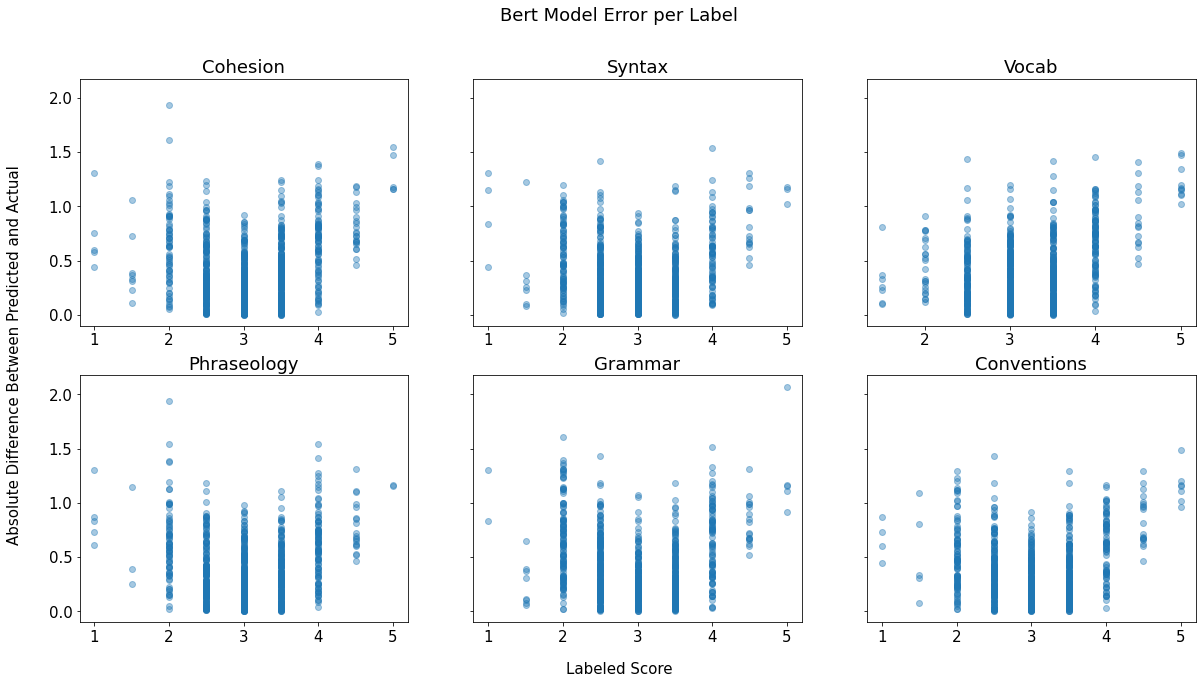

In [ ]:
plt.rcParams.update({'font.size': 15})

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True)
fig.suptitle('Bert Model Error per Label')
fig.set_figheight(10)
fig.set_figwidth(20)

#cohesion
ax1.scatter(cohesion_df_bert.actual, cohesion_df_bert.difference, alpha=0.4)
ax1.title.set_text('Cohesion')

#syntax
ax2.scatter(syntax_df_bert.actual, syntax_df_bert.difference, alpha=0.4)
ax2.title.set_text('Syntax')

#vocab
ax3.scatter(vocab_df_bert.actual, vocab_df_bert.difference, alpha=0.4)
ax3.title.set_text('Vocab')

#phraseology
ax4.scatter(phrase_df_bert.actual, phrase_df_bert.difference, alpha=0.4)
ax4.title.set_text('Phraseology')

#grammar
ax5.scatter(grammar_df_bert.actual, grammar_df_bert.difference, alpha=0.4)
ax5.title.set_text('Grammar')

#conventions
ax6.scatter(conv_df_bert.actual, conv_df_bert.difference, alpha=0.4)
ax6.title.set_text('Conventions')


# Set common labels
fig.text(0.5, 0.06, 'Labeled Score', ha='center', va='center')
fig.text(0.08, 0.5, 'Absolute Difference Between Predicted and Actual ', ha='center', va='center', rotation='vertical')

fig.show()
# RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


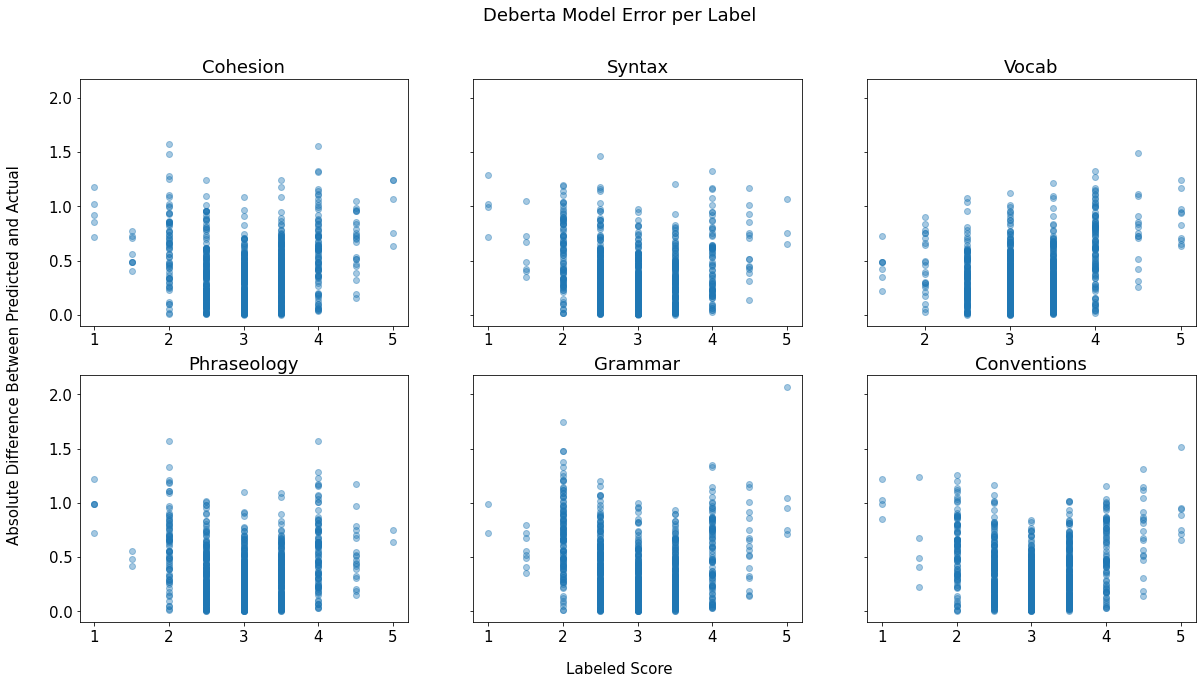

In [ ]:
plt.rcParams.update({'font.size': 15})

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True)
fig.suptitle('Deberta Model Error per Label')
fig.set_figheight(10)
fig.set_figwidth(20)

#cohesion
ax1.scatter(cohesion_df_deberta.actual, cohesion_df_deberta.difference, alpha=0.4)
ax1.title.set_text('Cohesion')

#syntax
ax2.scatter(syntax_df_deberta.actual, syntax_df_deberta.difference, alpha=0.4)
ax2.title.set_text('Syntax')

#vocab
ax3.scatter(vocab_df_deberta.actual, vocab_df_deberta.difference, alpha=0.4)
ax3.title.set_text('Vocab')

#phraseology
ax4.scatter(phrase_df_deberta.actual, phrase_df_deberta.difference, alpha=0.4)
ax4.title.set_text('Phraseology')

#grammar
ax5.scatter(grammar_df_deberta.actual, grammar_df_deberta.difference, alpha=0.4)
ax5.title.set_text('Grammar')

#conventions
ax6.scatter(conv_df_deberta.actual, conv_df_deberta.difference, alpha=0.4)
ax6.title.set_text('Conventions')


# Set common labels
fig.text(0.5, 0.06, 'Labeled Score', ha='center', va='center')
fig.text(0.08, 0.5, 'Absolute Difference Between Predicted and Actual ', ha='center', va='center', rotation='vertical')

fig.show()
# RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
# Write df's to file
cohesion_df_bert.to_csv('data/residuals/cohesion_df_bert.csv') 
syntax_df_bert.to_csv('data/residuals/syntax_df_bert.csv') 
vocab_df_bert.to_csv('data/residuals/vocab_df_bert.csv') 
phrase_df_bert.to_csv('data/residuals/phrase_df_bert.csv') 
grammar_df_bert.to_csv('data/residuals/grammar_df_bert.csv') 
conv_df_bert.to_csv('data/residuals/conv_df_bert.csv') 

cohesion_df_deberta.to_csv('data/residuals/cohesion_df_deberta.csv')
syntax_df_deberta.to_csv('data/residuals/syntax_df_deberta.csv')
vocab_df_deberta.to_csv('data/residuals/vocab_df_deberta.csv')
phrase_df_deberta.to_csv('data/residuals/phrase_df_deberta.csv')
grammar_df_deberta.to_csv('data/residuals/grammar_df_deberta.csv')
conv_df_deberta.to_csv('data/residuals/conv_df_deberta.csv') 

In [ ]:
# Read df's from file
cohesion_df_bert = pd.read_csv('data/residuals/cohesion_df_bert.csv') 
syntax_df_bert = pd.read_csv('data/residuals/syntax_df_bert.csv') 
vocab_df_bert = pd.read_csv('data/residuals/vocab_df_bert.csv') 
phrase_df_bert = pd.read_csv('data/residuals/phrase_df_bert.csv') 
grammar_df_bert = pd.read_csv('data/residuals/grammar_df_bert.csv') 
conv_df_bert = pd.read_csv('data/residuals/conv_df_bert.csv') 

cohesion_df_deberta = pd.read_csv('data/residuals/cohesion_df_deberta.csv')
syntax_df_deberta = pd.read_csv('data/residuals/syntax_df_deberta.csv')
vocab_df_deberta = pd.read_csv('data/residuals/vocab_df_deberta.csv')
phrase_df_deberta = pd.read_csv('data/residuals/phrase_df_deberta.csv')
grammar_df_deberta = pd.read_csv('data/residuals/grammar_df_deberta.csv')
conv_df_deberta = pd.read_csv('data/residuals/conv_df_deberta.csv') 

## Residuals Plot

In [ ]:
# Create column of residuals (not absolute value of the differences)
cohesion_df_bert['resid'] = cohesion_df_bert['pred'] - cohesion_df_bert['actual']
cohesion_df_bert

,Unnamed: 0,pred,actual,difference,resid
0,0,3.224495,3.0,0.224495,0.224495
1,1,3.080727,2.5,0.580727,0.580727
2,2,3.442106,4.0,0.557894,-0.557894
3,3,3.202379,4.0,0.797621,-0.797621
4,4,3.740377,4.0,0.259623,-0.259623
...,...,...,...,...,...
777,777,2.708810,3.5,0.791190,-0.791190
778,778,2.242751,2.5,0.257249,-0.257249
779,779,3.433390,3.0,0.433390,0.433390
780,780,3.161861,4.0,0.838139,-0.838139


In [ ]:
# Calculate mean residual grouped by actual score
cohesion_bert_resid_grouped = cohesion_df_bert.groupby('actual')['resid'].mean()
cohesion_bert_resid_grouped

actual
1.0    0.736000
1.5    0.440721
2.0    0.622567
2.5    0.288957
3.0    0.009557
3.5   -0.320629
4.0   -0.653484
4.5   -0.800532
5.0   -1.302498
Name: resid, dtype: float64

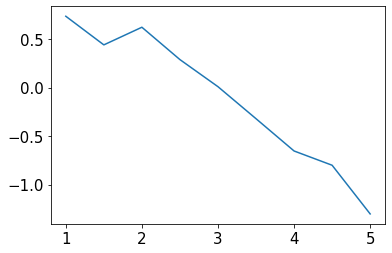

In [ ]:
plt.plot(cohesion_bert_resid_grouped)
plt.show()

In [ ]:
cohesion_df_deberta['resid'] = cohesion_df_deberta['pred'] - cohesion_df_deberta['actual']
cohesion_df_deberta_resid_grouped = cohesion_df_deberta.groupby('actual')['resid'].mean()
cohesion_df_deberta_resid_grouped

actual
1.0    0.937883
1.5    0.578690
2.0    0.620878
2.5    0.300757
3.0    0.065554
3.5   -0.290012
4.0   -0.557713
4.5   -0.661219
5.0   -0.988176
Name: resid, dtype: float64

In [ ]:
cohesion_df_deberta_resid_grouped.index

Float64Index([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], dtype='float64', name='actual')

In [ ]:
cohesion_df_deberta_resid_grouped.values

array([ 0.93788274,  0.57868955,  0.62087836,  0.30075713,  0.06555437,
       -0.29001246, -0.55771317, -0.66121944, -0.98817598])

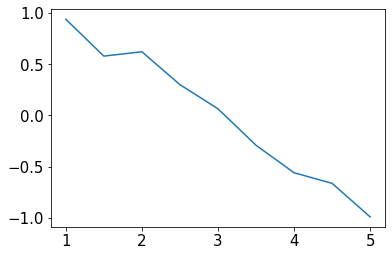

In [ ]:
plt.plot(cohesion_df_deberta_resid_grouped)
plt.show()

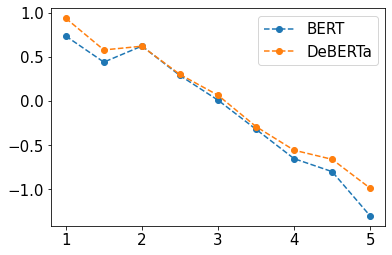

In [ ]:
plt.plot(cohesion_bert_resid_grouped.index, cohesion_bert_resid_grouped.values, '--o', label = "BERT")
plt.plot(cohesion_df_deberta_resid_grouped.index, cohesion_df_deberta_resid_grouped.values, '--o', label = "DeBERTa")
plt.legend()
plt.show()

In [ ]:
cohesion_df_bert['resid'] = cohesion_df_bert['pred'] - cohesion_df_bert['actual']
cohesion_bert_resid_grouped = cohesion_df_bert.groupby('actual')['resid'].mean()
syntax_df_bert['resid'] = syntax_df_bert['pred'] - syntax_df_bert['actual']
syntax_bert_resid_grouped = syntax_df_bert.groupby('actual')['resid'].mean()
vocab_df_bert['resid'] = vocab_df_bert['pred'] - vocab_df_bert['actual']
vocab_bert_resid_grouped = vocab_df_bert.groupby('actual')['resid'].mean()
phrase_df_bert['resid'] = phrase_df_bert['pred'] - phrase_df_bert['actual']
phrase_bert_resid_grouped = phrase_df_bert.groupby('actual')['resid'].mean()
grammar_df_bert['resid'] = grammar_df_bert['pred'] - grammar_df_bert['actual']
grammar_bert_resid_grouped = grammar_df_bert.groupby('actual')['resid'].mean()
conv_df_bert['resid'] = conv_df_bert['pred'] - conv_df_bert['actual']
conv_bert_resid_grouped = conv_df_bert.groupby('actual')['resid'].mean()


cohesion_df_deberta['resid'] = cohesion_df_deberta['pred'] - cohesion_df_deberta['actual']
cohesion_df_deberta_resid_grouped = cohesion_df_deberta.groupby('actual')['resid'].mean()
syntax_df_deberta['resid'] = syntax_df_deberta['pred'] - syntax_df_deberta['actual']
syntax_df_deberta_resid_grouped = syntax_df_deberta.groupby('actual')['resid'].mean()
vocab_df_deberta['resid'] = vocab_df_deberta['pred'] - vocab_df_deberta['actual']
vocab_df_deberta_resid_grouped = vocab_df_deberta.groupby('actual')['resid'].mean()
phrase_df_deberta['resid'] = phrase_df_deberta['pred'] - phrase_df_deberta['actual']
phrase_df_deberta_resid_grouped = phrase_df_deberta.groupby('actual')['resid'].mean()
grammar_df_deberta['resid'] = grammar_df_deberta['pred'] - grammar_df_deberta['actual']
grammar_df_deberta_resid_grouped = grammar_df_deberta.groupby('actual')['resid'].mean()
conv_df_deberta['resid'] = conv_df_deberta['pred'] - conv_df_deberta['actual']
conv_df_deberta_resid_grouped = conv_df_deberta.groupby('actual')['resid'].mean()

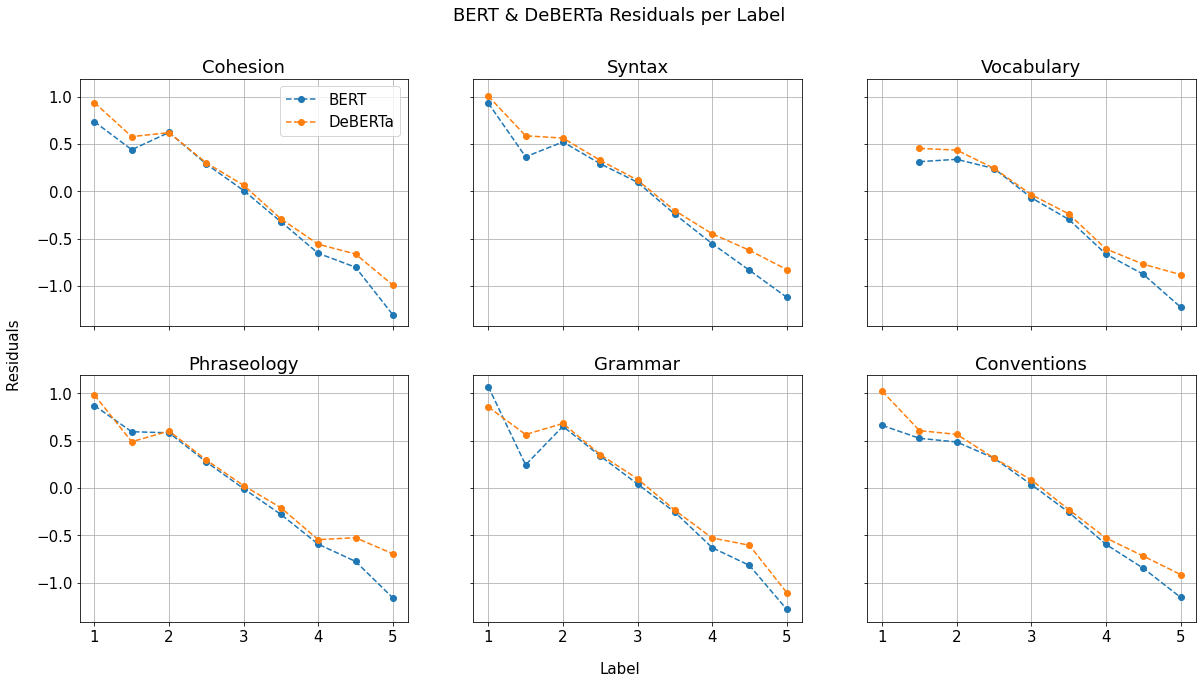

In [ ]:
plt.rcParams.update({'font.size': 15})

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
fig.suptitle('BERT & DeBERTa Residuals per Label')
fig.set_figheight(10)
fig.set_figwidth(20)

#cohesion
ax1.plot(cohesion_bert_resid_grouped.index, cohesion_bert_resid_grouped.values, '--o', label = "BERT")
ax1.plot(cohesion_df_deberta_resid_grouped.index, cohesion_df_deberta_resid_grouped.values, '--o', label = "DeBERTa")
ax1.grid()
ax1.legend()
ax1.title.set_text('Cohesion')

#syntax
ax2.plot(syntax_bert_resid_grouped.index, syntax_bert_resid_grouped.values, '--o', label = "BERT")
ax2.plot(syntax_df_deberta_resid_grouped.index, syntax_df_deberta_resid_grouped.values, '--o', label = "DeBERTa")
ax2.grid()
# ax2.legend()
ax2.title.set_text('Syntax')

#vocab
ax3.plot(vocab_bert_resid_grouped.index, vocab_bert_resid_grouped.values, '--o', label = "BERT")
ax3.plot(vocab_df_deberta_resid_grouped.index, vocab_df_deberta_resid_grouped.values, '--o', label = "DeBERTa")
ax3.grid()
# ax3.legend()
ax3.title.set_text('Vocabulary')

#phraseology
ax4.plot(phrase_bert_resid_grouped.index, phrase_bert_resid_grouped.values, '--o', label = "BERT")
ax4.plot(phrase_df_deberta_resid_grouped.index, phrase_df_deberta_resid_grouped.values, '--o', label = "DeBERTa")
ax4.grid()
# ax4.legend()
ax4.title.set_text('Phraseology')

#grammar
ax5.plot(grammar_bert_resid_grouped.index, grammar_bert_resid_grouped.values, '--o', label = "BERT")
ax5.plot(grammar_df_deberta_resid_grouped.index, grammar_df_deberta_resid_grouped.values, '--o', label = "DeBERTa")
ax5.grid()
# ax5.legend()
ax5.title.set_text('Grammar')

#conventions
ax6.plot(conv_bert_resid_grouped.index, conv_bert_resid_grouped.values, '--o', label = "BERT")
ax6.plot(conv_df_deberta_resid_grouped.index, conv_df_deberta_resid_grouped.values, '--o', label = "DeBERTa")
ax6.grid()
# ax6.legend()
ax6.title.set_text('Conventions')


# Set common labels
fig.text(0.5, 0.06, 'Label', ha='center', va='center')
fig.text(0.08, 0.5, 'Residuals ', ha='center', va='center', rotation='vertical')
fig.show()

In [ ]:
cohesion_df_bert.groupby('actual')['difference'].mean().values

array([0.73599961, 0.44072139, 0.63239369, 0.38941377, 0.29320072,
       0.37611098, 0.65547536, 0.80053176, 1.30249796])

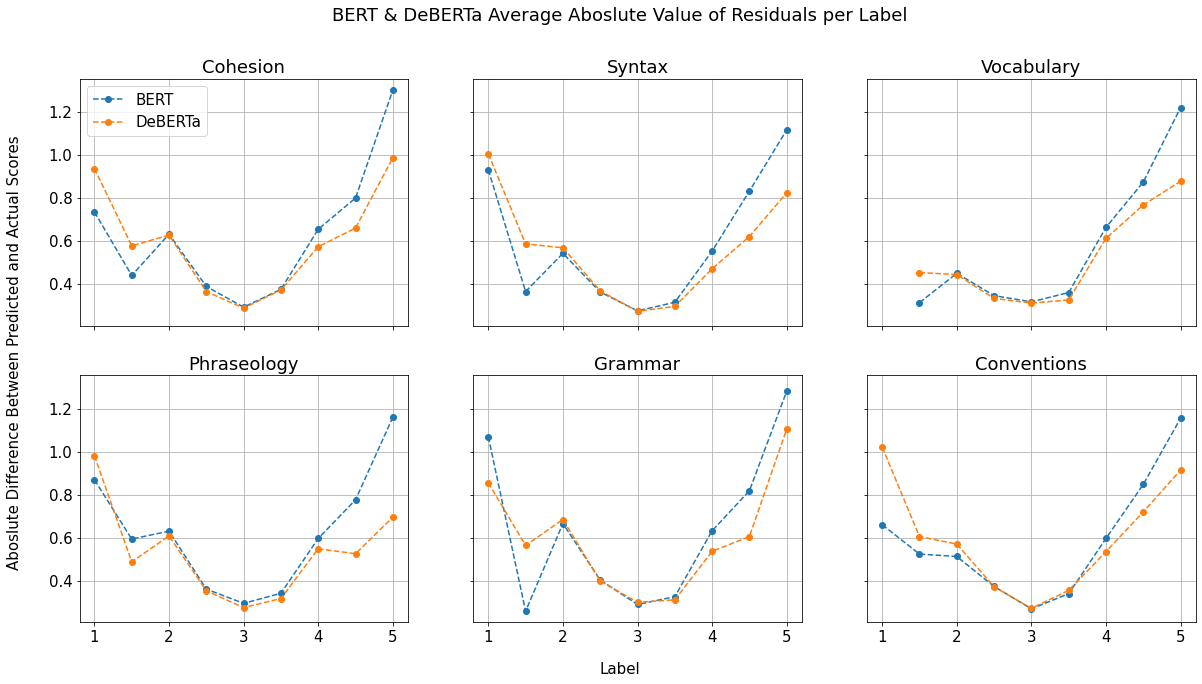

In [ ]:
plt.rcParams.update({'font.size': 15})

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
fig.suptitle('BERT & DeBERTa Average Aboslute Value of Residuals per Label')
fig.set_figheight(10)
fig.set_figwidth(20)

#cohesion
ax1.plot(cohesion_df_bert.groupby('actual')['difference'].mean().index, cohesion_df_bert.groupby('actual')['difference'].mean().values, '--o', label = "BERT")
ax1.plot(cohesion_df_deberta.groupby('actual')['difference'].mean().index, cohesion_df_deberta.groupby('actual')['difference'].mean().values, '--o', label = "DeBERTa")
ax1.grid()
ax1.legend()
ax1.title.set_text('Cohesion')

#syntax
ax2.plot(syntax_df_bert.groupby('actual')['difference'].mean().index, syntax_df_bert.groupby('actual')['difference'].mean().values, '--o', label = "BERT")
ax2.plot(syntax_df_deberta.groupby('actual')['difference'].mean().index, syntax_df_deberta.groupby('actual')['difference'].mean().values, '--o', label = "DeBERTa")
ax2.grid()
# ax2.legend()
ax2.title.set_text('Syntax')

#vocab
ax3.plot(vocab_df_bert.groupby('actual')['difference'].mean().index, vocab_df_bert.groupby('actual')['difference'].mean().values, '--o', label = "BERT")
ax3.plot(vocab_df_deberta.groupby('actual')['difference'].mean().index, vocab_df_deberta.groupby('actual')['difference'].mean().values, '--o', label = "DeBERTa")
ax3.grid()
# ax3.legend()
ax3.title.set_text('Vocabulary')

#phraseology
ax4.plot(phrase_df_bert.groupby('actual')['difference'].mean().index, phrase_df_bert.groupby('actual')['difference'].mean().values, '--o', label = "BERT")
ax4.plot(phrase_df_deberta.groupby('actual')['difference'].mean().index, phrase_df_deberta.groupby('actual')['difference'].mean().values, '--o', label = "DeBERTa")
ax4.grid()
# ax4.legend()
ax4.title.set_text('Phraseology')

#grammar
ax5.plot(grammar_df_bert.groupby('actual')['difference'].mean().index, grammar_df_bert.groupby('actual')['difference'].mean().values, '--o', label = "BERT")
ax5.plot(grammar_df_deberta.groupby('actual')['difference'].mean().index, grammar_df_deberta.groupby('actual')['difference'].mean().values, '--o', label = "DeBERTa")
ax5.grid()
# ax5.legend()
ax5.title.set_text('Grammar')

#conventions
ax6.plot(conv_df_bert.groupby('actual')['difference'].mean().index, conv_df_bert.groupby('actual')['difference'].mean().values, '--o', label = "BERT")
ax6.plot(conv_df_deberta.groupby('actual')['difference'].mean().index, conv_df_deberta.groupby('actual')['difference'].mean().values, '--o', label = "DeBERTa")
ax6.grid()
# ax6.legend()
ax6.title.set_text('Conventions')


# Set common labels
fig.text(0.5, 0.06, 'Label', ha='center', va='center')
fig.text(0.08, 0.5, 'Aboslute Difference Between Predicted and Actual Scores', ha='center', va='center', rotation='vertical')
fig.show()